Repeat the same process of the previous notebook, using different measurements.\
__BOSS CMASS Sample__: with the large sample size and availability of spectroscopic redshifts for all BOSS galaxies allowed the BOSS collaboration to measure the BAO signature with an uncertainty of $1\%$ for the case
of the BOSS CMASS sample, which is the most constraining BAO measurement to date.\
The higher redshift sample CMASS covers redshifts $0.43 < z < 0.75$ and is designed to select a stellar mass-limited sample of objects of all intrinsic colors, with a color cut that selects almost exclusively on redshift. The CMASS galaxy
sample is selected by the combination of the 7 different color and magnitude cuts.\
*From [Producing a BOSS-CMASS sample with DES imaging](https://arxiv.org/pdf/1906.01136.pdf)*.

In [1]:
import os, sys
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import matplotlib.pyplot as plt
import yaml

# Define chain folder
chain_dir = os.path.join(os.getcwd(), 'chains/perlmutter/')

# Whether to plot prior and posterior distributions
plotting = False 

from getdist import loadMCSamples, plots, mcsamples, MCSamples
from python_scripts.prior import * 
from python_scripts.utils import *

2023-12-15 13:17:12.084499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 13:17:12.410487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 13:17:12.410601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 13:17:12.411070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 13:17:12.567724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 13:17:12.571316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### 1.BOSS CMASS: $p_k$ with $1$ sky-cut1, WC prior, BBN prior
For sampling the prior distributions we can exploit the chains generated in the previous notebook. Specifically, we generate here those that do not require the use of CLASS (long time of execution), later adding the $\sigma_8$ prior from the chains built for the case of BOSS + BBN Prior.

In [2]:
wc_posterior = loadMCSamples(file_root=chain_dir+'/cmass_wc_std/2023-12-14_10000_', settings={'ignore_rows':0.3})
wc_posterior.name_tag = 'CMASS WC'

param_limits, wc_prior = full_prior(root_dir=chain_dir+'cmass_wc_std/', chain_name='2023-12-14_10000_', 
                                                config_name='cmass_wc_std', name_tag='CMASS WC Prior',
                                                include_class=False)

List of "cosmological" parameters: ['omega_b', 'omega_cdm', 'h', 'ln10^{10}A_s', 'n_s']
List of "derived"      parameters: ['Omega_m', 'A_s']
List of "nuisance"     parameters: ['b1', 'c2']

Fixed Parameter Limits:
omega_cdm    | (0.08, 0.16)  
h            | (0.635, 0.715)
ln10^{10}A_s | (2.644, 3.444)
n_s          | (0.765, 1.165)
b1           | (0.0, 4.0)    
c2           | (-10.0, 10.0) 



In [3]:
boss_prior = loadMCSamples(file_root=chain_dir+'/eftboss_wc_std/cosmo_prior_', no_cache=True)
p = boss_prior.getParams()
wc_prior.addDerived(p.sigma8, name='sigma8', label='\sigma_8')

Showing a bit more non-gaussianities if compared to BOSS samples.

In [4]:
wc_cosmo_names = ['omega_b', 'omega_cdm', 'h', 'ln10^{10}A_s', 'n_s', 'Omega_m', 'A_s', 'sigma8']
wc_nuisance_names = ['b1', 'c2']
if plotting:
    # Plotting cosmological parameters
    g = plots.get_subplot_plotter(width_inch=9)
    g.settings.alpha_filled_add = 0.3
    g.settings.title_limit_fontsize = 0.8
    g.triangle_plot([wc_posterior, wc_prior], wc_cosmo_names, title_limit=1,
                    filled=True,
                    param_limits=param_limits);

In [5]:
if plotting:
    # Plotting cosmological parameters
    g = plots.get_subplot_plotter(width_inch=4)
    g.settings.alpha_filled_add = 0.3
    g.settings.title_limit_fontsize = 0.8
    g.triangle_plot([wc_posterior, wc_prior], wc_nuisance_names, title_limit=1,
                    filled=True,
                    param_limits=param_limits);

Non-log N_eff 	= 5.9741

Improvement factor over the prior: [1819.3   896.53   32.53   17.97    6.69    3.12    2.14    0.96]
Discarding error units due to negative values.


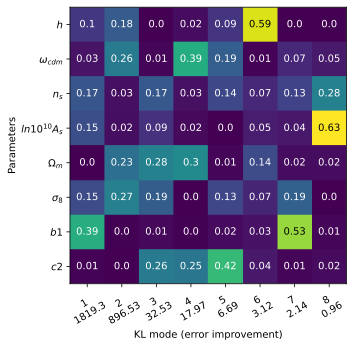

In [6]:
# Re-definition of params
wc_params = ['h', 'omega_cdm', 'n_s', 'ln10^{10}A_s', 'Omega_m', 'sigma8', 'b1', 'c2']
wc_labels = ['h', '\omega_{cdm}', 'n_s', '\ln{10^{10}A_s}', '\Omega_m', '\sigma_8', 'b1', 'c2']

KL_eig, KL_eigv, KL_param_names = plot_frac_fisher(prior_chain=wc_prior, posterior_chain=wc_posterior, 
                                                   params=wc_params, labels=wc_labels, norm=True,
                                                   print_improvement=True)

**Prior Shrinking**

In [7]:
idx = [wc_posterior.index[name] for name in KL_param_names]
prior_mean = wc_prior.getMeans(pars=[wc_prior.index[name] for name in KL_param_names])
posterior_mean = wc_posterior.getMeans(pars=[wc_posterior.index[name] for name in KL_param_names])
inv_KL_eigv = np.linalg.inv(KL_eigv)
# Only keeping the first 12 modes
inv_KL_eigv[6:,:] = 0.
# Project the shifted posterior samples on the KL modes
wc_KL_filtered_samples = np.dot(np.dot(wc_posterior.samples[:,idx]-prior_mean, KL_eigv), inv_KL_eigv)+prior_mean

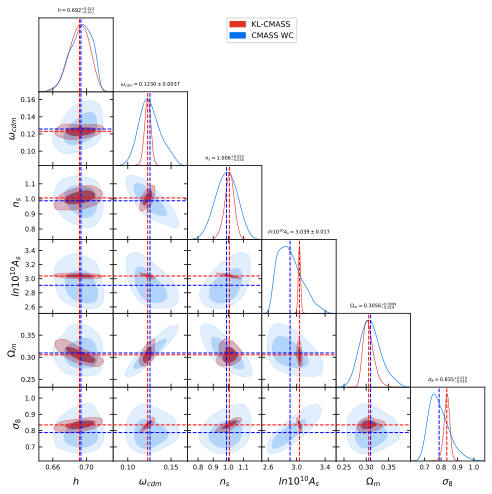

In [8]:
# Prior Shrinking - Cosmological Parameters
wc_KL_chain = MCSamples(samples=wc_KL_filtered_samples, 
                     loglikes=wc_posterior.loglikes, 
                     weights=wc_posterior.weights, 
                     names=wc_params, 
                     labels=[name.label for name in wc_posterior.getParamNames().parsWithNames(wc_params)], 
                     label='KL-CMASS WC',
                     settings={'ignore_rows':0.})
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
# Cosmological Parameters
temp_params = wc_params[:6]
g.triangle_plot([wc_KL_chain, wc_posterior], params=temp_params, filled=True, title_limit=1)
wc_KL_means = wc_KL_chain.getMeans(pars=[wc_KL_chain.index[name] for name in temp_params])
wc_means = wc_posterior.getMeans(pars=[wc_posterior.index[name] for name in temp_params])
# Display mean indicators
for i in range(len(temp_params)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(wc_KL_means[i], color='red', lw=1., ls='--')
        ax.axvline(wc_means[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(wc_KL_means[i], color='red', lw=1., ls='--')
        ax.axhline(wc_means[i], color='blue', lw=1., ls='--')

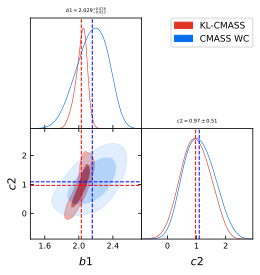

In [9]:
# Prior Shrinking - EFT Parameters
g = plots.get_subplot_plotter(width_inch=4)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
temp_params = wc_params[6:]
g.triangle_plot([wc_KL_chain, wc_posterior], params=temp_params, filled=True, title_limit=1)
wc_KL_means = wc_KL_chain.getMeans(pars=[wc_KL_chain.index[name] for name in temp_params])
wc_means = wc_posterior.getMeans(pars=[wc_posterior.index[name] for name in temp_params])
# Display mean indicators
for i in range(len(temp_params)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(wc_KL_means[i], color='red', lw=1., ls='--')
        ax.axvline(wc_means[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(wc_KL_means[i], color='red', lw=1., ls='--')
        ax.axhline(wc_means[i], color='blue', lw=1., ls='--')

Combining the information from the fractional Fisher matrix and the plots above, we can see that $b1$ once again plays a crucial role in the information provided to the mode with maximum variance preserved. However, in this case the fraction is decidedly smaller than the BOSS scenario, with significant contributions also from $n_s$, $\ln{10^{10}A_s}$ and $\sigma_8$.\
We can also find these considerations in the prior-shrinking plots, where we see a certain difference on the 2D $b1-c2$ plane between the prior-filtered and original distributions.\
However, we see how the contribution of $\ln{10^{10}A_s}$ is limited to the first mode and remains almost negligible until the last one. So it is not surprising to see a considerable difference in the posteriors following the prior removal.

### 2.BOSS CMASS: $p_k$ with $1$ sky-cut1, EC prior, BBN prior

In [10]:
ec_posterior = loadMCSamples(file_root=chain_dir+'/cmass_ec_std/2023-12-13_10000_', settings={'ignore_rows':0.3})
ec_posterior.name_tag = 'CMASS EC'

In [11]:
param_limits, ec_prior = full_prior(root_dir=chain_dir+'cmass_ec_std/', chain_name='2023-12-13_10000_', 
                                                config_name='cmass_ec_std', name_tag='CMASS EC Prior',
                                                include_class=False)

List of "cosmological" parameters: ['omega_b', 'omega_cdm', 'h', 'ln10^{10}A_s', 'n_s']
List of "derived"      parameters: ['Omega_m', 'A_s']
List of "nuisance"     parameters: ['b1', 'bt2', 'bG2']

Fixed Parameter Limits:
omega_cdm    | (0.08, 0.16)  
h            | (0.635, 0.715)
ln10^{10}A_s | (2.644, 3.444)
n_s          | (0.765, 1.165)
b1           | (0.0, 4.0)    
bt2          | (-1.0, 1.0)   
bG2          | (-1.0, 1.0)   



In [13]:
# No problem using the WC configuration, since the cosmological parameters all have the same prior
boss_prior = loadMCSamples(file_root=chain_dir+'/eftboss_wc_std/cosmo_prior_', no_cache=True)
p = boss_prior.getParams()
ec_prior.addDerived(p.sigma8, name='sigma8', label='\sigma_8')

In [14]:
ec_cosmo_names = ['omega_b', 'omega_cdm', 'h', 'ln10^{10}A_s', 'n_s', 'Omega_m', 'A_s', 'sigma8']
ec_nuisance_names = ['b1', 'bt2', 'bG2']
if plotting:
    # Plotting cosmological parameters
    g = plots.get_subplot_plotter(width_inch=9)
    g.settings.alpha_filled_add = 0.3
    g.settings.title_limit_fontsize = 0.8
    g.triangle_plot([ec_posterior, ec_prior], ec_cosmo_names, title_limit=1,
                    filled=True,
                    param_limits=param_limits);

In [15]:
if plotting:
    # Plotting cosmological parameters
    g = plots.get_subplot_plotter(width_inch=4)
    g.settings.alpha_filled_add = 0.3
    g.settings.title_limit_fontsize = 0.8
    g.triangle_plot([wc_posterior, wc_prior], wc_nuisance_names, title_limit=1,
                    filled=True,
                    param_limits=param_limits);

Non-log N_eff 	= 5.5798

Improvement factor over the prior: [984.79 911.6   15.39   8.46   2.76   2.29   2.03   1.06   0.96]
Discarding error units due to negative values.


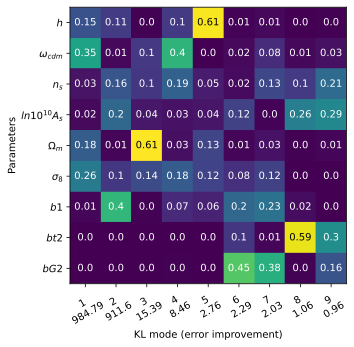

In [16]:
# Re-definition of params
ec_params = ['h', 'omega_cdm', 'n_s', 'ln10^{10}A_s', 'Omega_m', 'sigma8', 'b1', 'bt2', 'bG2']
ec_labels = ['h', '\omega_{cdm}', 'n_s', '\ln{10^{10}A_s}', '\Omega_m', '\sigma_8', 'b1', 'bt2', 'bG2']

KL_eig, KL_eigv, KL_param_names = plot_frac_fisher(prior_chain=ec_prior, posterior_chain=ec_posterior, 
                                                   params=ec_params, labels=ec_labels, norm=True,
                                                   print_improvement=True)

**Prior Shrinking**

In [17]:
idx = [ec_posterior.index[name] for name in KL_param_names]
prior_mean = ec_prior.getMeans(pars=[ec_prior.index[name] for name in KL_param_names])
posterior_mean = ec_posterior.getMeans(pars=[ec_posterior.index[name] for name in KL_param_names])
inv_KL_eigv = np.linalg.inv(KL_eigv)
# Only keeping the first 12 modes
inv_KL_eigv[6:,:] = 0.
# Project the shifted posterior samples on the KL modes
ec_KL_filtered_samples = np.dot(np.dot(ec_posterior.samples[:,idx]-prior_mean, KL_eigv), inv_KL_eigv)+prior_mean

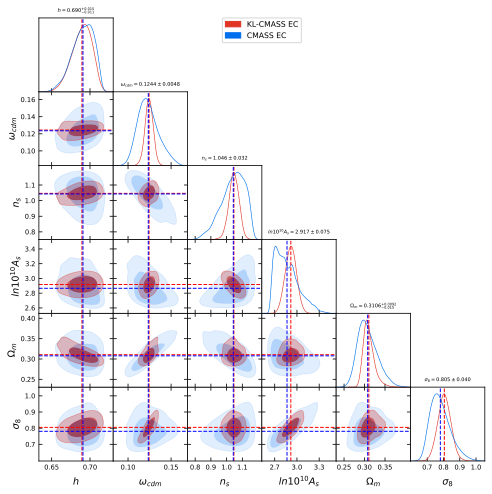

In [18]:
# Prior Shrinking - Cosmological Parameters
ec_KL_chain = MCSamples(samples=ec_KL_filtered_samples, 
                     loglikes=ec_posterior.loglikes, 
                     weights=ec_posterior.weights, 
                     names=ec_params, 
                     labels=[name.label for name in ec_posterior.getParamNames().parsWithNames(ec_params)], 
                     label='KL-CMASS EC',
                     settings={'ignore_rows':0.})
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
# Cosmological Parameters
temp_params = ec_params[:6]
g.triangle_plot([ec_KL_chain, ec_posterior], params=temp_params, filled=True, title_limit=1)
ec_KL_means = ec_KL_chain.getMeans(pars=[ec_KL_chain.index[name] for name in temp_params])
ec_means = ec_posterior.getMeans(pars=[ec_posterior.index[name] for name in temp_params])
# Display mean indicators
for i in range(len(temp_params)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(ec_KL_means[i], color='red', lw=1., ls='--')
        ax.axvline(ec_means[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(ec_KL_means[i], color='red', lw=1., ls='--')
        ax.axhline(ec_means[i], color='blue', lw=1., ls='--')

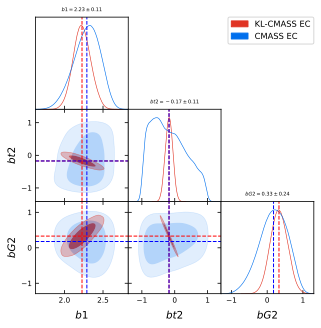

In [19]:
# Prior Shrinking - EFT Parameters
g = plots.get_subplot_plotter(width_inch=5)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
temp_params = ec_params[6:]
g.triangle_plot([ec_KL_chain, ec_posterior], params=temp_params, filled=True, title_limit=1)
ec_KL_means = ec_KL_chain.getMeans(pars=[ec_KL_chain.index[name] for name in temp_params])
ec_means = ec_posterior.getMeans(pars=[ec_posterior.index[name] for name in temp_params])
# Display mean indicators
for i in range(len(temp_params)):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(ec_KL_means[i], color='red', lw=1., ls='--')
        ax.axvline(ec_means[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(ec_KL_means[i], color='red', lw=1., ls='--')
        ax.axhline(ec_means[i], color='blue', lw=1., ls='--')

We can now see that the EFT parameters are much less smooth than in the BOSS case. Let us take $bt2$ as an example: in Fisher's matrix we observe that its contribution is almost negligible until the penultimate mode, which in turn has a very low contribution in the total variance, so that it is excluded in $N_{eff}$. So again, the difference in the distrbutions of $bt2$ is not surprising, and indeed confirms an important difference with the case of BOSS: here the EFT parameters are more constrained by the prior.